In [195]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [412]:
# 3. Supply Chain Efficiency Improvement Project

# 3.1 Introduction
# This project aims to analyze supplier performance and identify bottlenecks in order fulfillment processes to enhance the overall efficiency of the supply chain.


In [413]:
# 3.2 Data Preparation

# import libraries
import os
import re
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

# change directory
os.chdir('/content/drive/MyDrive/DSA3101')

# load datasets
orders = pd.read_csv('Orders Table.csv')
products = pd.read_csv('Products Table.csv')

# merge datasets on ProductID
data = pd.merge(orders, products, on='ProductID', how='left')

In [414]:
# 3.3 Data Inspection

# Inspect the datasets
print(orders.head())
print(products.head())

# Check for missing values
print(orders.isnull().sum())
print(products.isnull().sum())

   OrderID  ProductID  CustomerID       Order Date    Shipping Date  \
0    77202       5246       15795  1/31/2018 22:56   2/3/2018 22:56   
1    75939       2362         860  1/13/2018 12:27  1/18/2018 12:27   
2    75938      13940       76820  1/13/2018 12:06  1/17/2018 12:06   
3    75937       1105       54886  1/13/2018 11:45  1/16/2018 11:45   
4    75936       2987        6265  1/13/2018 11:24  1/15/2018 11:24   

   Actual days for shipping  Scheduled days for shipping  Late Delivery Risk  \
0                         3                            4                   0   
1                         5                            4                   1   
2                         4                            4                   0   
3                         3                            4                   0   
4                         2                            4                   0   

   Discount Percentage  Returns  Promotional Period    Order Region  \
0                 0.0

In [415]:
# 3.4 Data Cleaning

# convert date columns to datetime format
orders['Order Date'] = pd.to_datetime(orders['Order Date'])
orders['Shipping Date'] = pd.to_datetime(orders['Shipping Date'])

In [416]:
# 3.5 Exploratory Data Analysis (EDA) & Bottleneck Identification

# 3.5.1 Descriptive Analysis
# 3.5.1.1 Summary Statistics
summary_stats = data.describe()
print("Summary Statistics:")
print(summary_stats)

# Insights from Summary Statistics:
# 1) Orders Table:
#    - There are 590,283 orders.
#    - The average actual shipping time is approximately 3.5 days.
#    - The late delivery risk is present in about 55% of the orders.
#    - On average, each order contains about 2.16 items.
#    - Returns occur in about 10% of the cases.

# 2) Products Table:
#    - There are 20,462 unique products.
#    - The prices ranging widely from $0.47 to $1,678.80.
#    - There are 150 unique suppliers.

Summary Statistics:
             OrderID      ProductID     CustomerID  Actual days for shipping  \
count  590283.000000  590283.000000  590283.000000             590283.000000   
mean    35009.658181   10220.769106   49962.797475                  3.495700   
std     20263.272582    5899.546843   28941.580773                  1.624511   
min         1.000000       1.000000       1.000000                  0.000000   
25%     17481.000000    5120.000000   24726.000000                  2.000000   
50%     35037.000000   10220.000000   50099.000000                  3.000000   
75%     52421.000000   15332.000000   75118.000000                  5.000000   
max     77204.000000   20462.000000   99999.000000                  6.000000   

       Scheduled days for shipping  Late Delivery Risk  Discount Percentage  \
count                590283.000000       590283.000000        590283.000000   
mean                      2.928998            0.548893             0.101742   
std                   

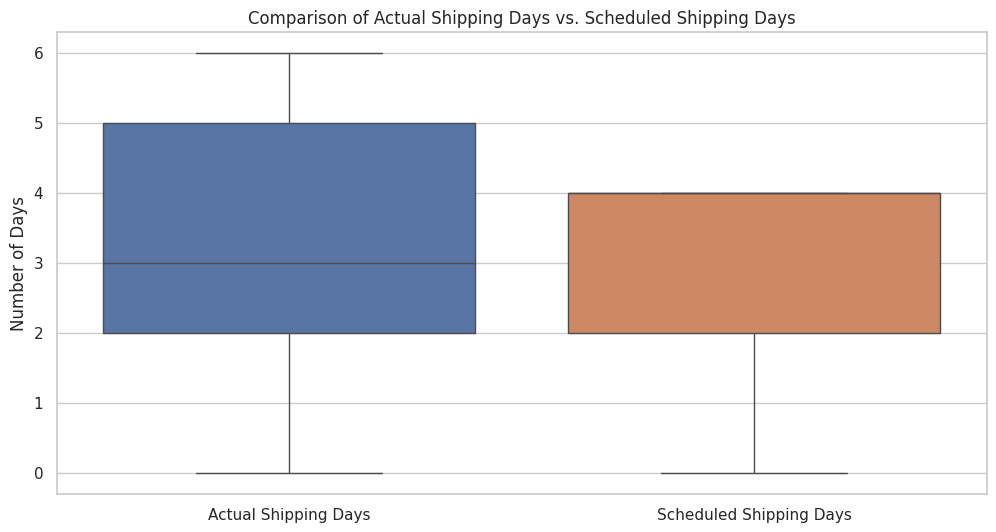

In [417]:
# 3.5.1.2 Box Plot: Actual Shipping Days vs. Scheduled Shipping Days

# Box Plot
plt.figure(figsize=(12, 6))
sns.boxplot(data=data[['Actual days for shipping', 'Scheduled days for shipping']])
plt.title('Comparison of Actual Shipping Days vs. Scheduled Shipping Days')
plt.ylabel('Number of Days')
plt.xticks(ticks=[0, 1], labels=['Actual Shipping Days', 'Scheduled Shipping Days'])
plt.show()

# Insights from Box Plots:
# 1) Median and IQR(Q3-Q1) of actual shipping days > scheduled days,
#    indicating inefficiencies in order fulfillment and potentially negative impact on customer satisfaction.
# 2) Next step will identify product categories/suppliers with longer shipping times


Supplier Performance Analysis (Late Delivery Percentage >= 60%):
     Supplier_ID  late_delivery_count  total_sales  late_delivery_percentage
43            44                   52           65                 80.000000
2              3                  260          363                 71.625344
48            49                   27           40                 67.500000
25            26                  472          711                 66.385373
14            15                  139          210                 66.190476
73            74                  181          274                 66.058394
64            65                  288          453                 63.576159
100          101                  232          365                 63.561644
13            14                  206          327                 62.996942
105          106                  321          512                 62.695312
27            28                   94          150                 62.666667
22         

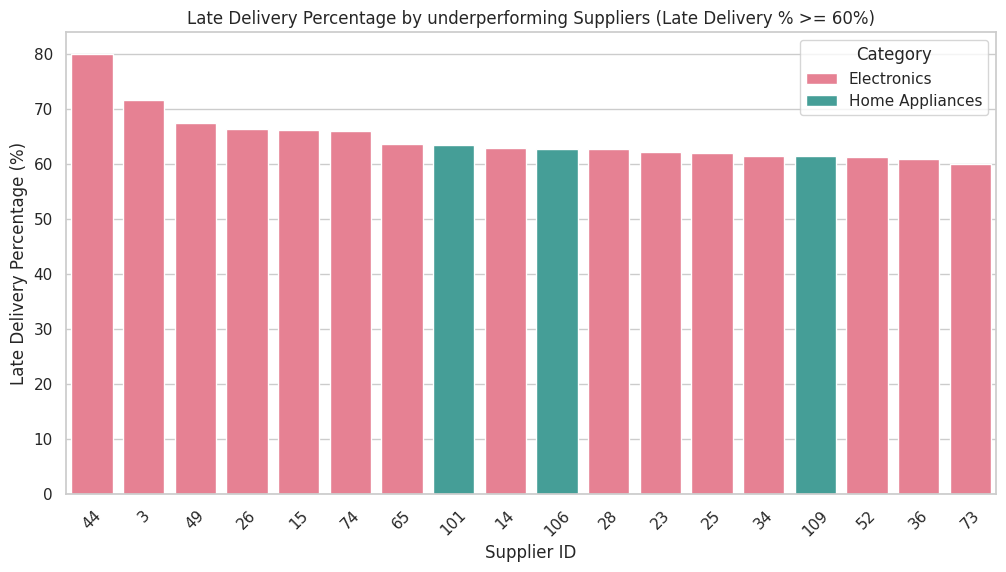

Percentage of underperforming Suppliers by Category (Late Delivery Percentage >= 60%):
          Category  total_suppliers  underperforming_suppliers  \
0         Clothing               33                        0.0   
1      Electronics               83                       15.0   
2  Home Appliances               34                        3.0   

   percentage_underperforming  
0                    0.000000  
1                   18.072289  
2                    8.823529  


In [418]:
# 3.5.2 Supplier Performance Analysis

# disclaimer: we did not include bar chart (Late Delivery Risk by Product Category) here as every categories have 50%-55% late delivery risk.

# hence, we try to analyze late delivery risk by suppliers now
supplier_performance = data.groupby('Supplier_ID').agg(
    late_delivery_count=('Late Delivery Risk', lambda x: (x == 1).sum()),
    total_sales=('ProductID', 'count')
).reset_index()

# calculate late delivery percentage for each supplier
supplier_performance['late_delivery_percentage'] = (supplier_performance['late_delivery_count'] / supplier_performance['total_sales']) * 100

# we classified suppliers with a late delivery percentage of >= 60% as underperforming suppliers,
# while those with a lower percentage are categorized as high-performing suppliers.
underperforming_suppliers = supplier_performance[supplier_performance['late_delivery_percentage'] >= 60]
underperforming_suppliers_sorted = underperforming_suppliers.sort_values(by='late_delivery_percentage', ascending=False)
print("Supplier Performance Analysis (Late Delivery Percentage >= 60%):")
print(underperforming_suppliers_sorted)

# categorize suppliers
underperforming_categories = data[data['Supplier_ID'].isin(underperforming_suppliers_sorted['Supplier_ID'])]

# merge the supplier performance with their categories
underperforming_suppliers_sorted = pd.merge(underperforming_suppliers_sorted, underperforming_categories[['Supplier_ID', 'Category']], on='Supplier_ID', how='left')

# Bar Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=underperforming_suppliers_sorted, x='Supplier_ID', y='late_delivery_percentage', hue='Category', palette='husl', order=underperforming_suppliers_sorted['Supplier_ID'])
plt.title('Late Delivery Percentage by underperforming Suppliers (Late Delivery % >= 60%)')
plt.xlabel('Supplier ID')
plt.ylabel('Late Delivery Percentage (%)')
plt.xticks(rotation=45)
plt.legend(title='Category')
plt.show()

# count total suppliers and underperforming suppliers
total_suppliers_by_category = data.groupby('Category')['Supplier_ID'].nunique().reset_index(name='total_suppliers')
underperforming_suppliers_by_category = underperforming_categories.groupby('Category')['Supplier_ID'].nunique().reset_index(name='underperforming_suppliers')

# merge the two dataframes to calculate percentages
category_analysis = pd.merge(total_suppliers_by_category, underperforming_suppliers_by_category, on='Category', how='left')
category_analysis['underperforming_suppliers'] = category_analysis['underperforming_suppliers'].fillna(0)
category_analysis['percentage_underperforming'] = (category_analysis['underperforming_suppliers'] / category_analysis['total_suppliers']) * 100
print("Percentage of underperforming Suppliers by Category (Late Delivery Percentage >= 60%):")
print(category_analysis[['Category', 'total_suppliers', 'underperforming_suppliers', 'percentage_underperforming']])

# Insights from Suppliers Performance Analysis:
# 1) There are 15 Electronics Suppliers and 3 Home Appliances Suppliers are underperforming.
# 2) Are Electronics and Home Appliances harder to transit, leading to this result?
#    Ans: No. As mentioned before, every categories have 50%-55% late delivery risk, so we cannot tell the difference of each categories' difficulty in transit.


                        Order Country  avg_late_delivery_percentage
52                         Madagascar                    100.000000
29                            Eritrea                    100.000000
91                              Túnez                    100.000000
85                             Suecia                    100.000000
78                            Senegal                    100.000000
71                           Portugal                    100.000000
65                              Níger                    100.000000
64                             Norway                    100.000000
59                            Myanmar                    100.000000
54                          Martinica                    100.000000
50                         Kazakhstan                    100.000000
41                            Hungría                    100.000000
37                          Guadalupe                    100.000000
33                              Gabón           

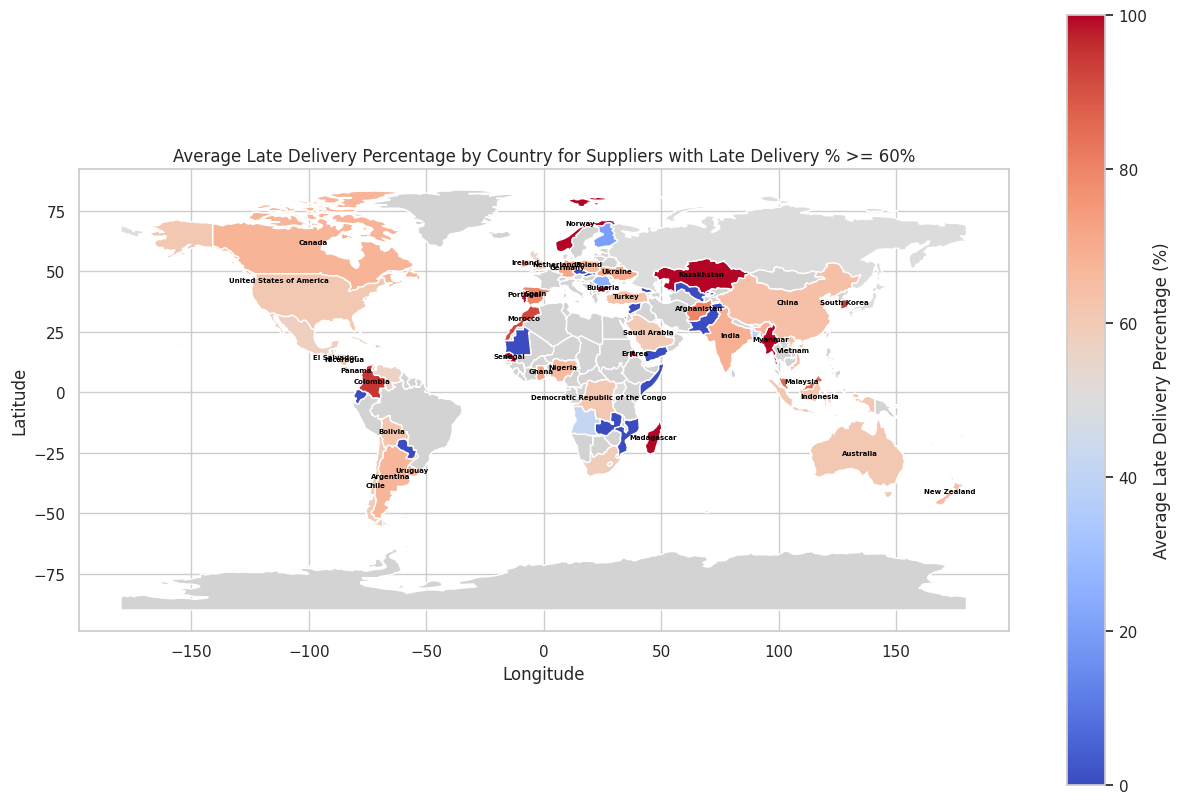

In [419]:
# 3.5.3 Order Fulfillment Process Analysis

# Now, we will identify underperforming suppliers in the countries they are responsible for,
# as this may indicate regional challenges such as customs clearance issues or inconvenient transportation.

# !unzip /content/ne_110m_admin_0_countries.zip -d /content/ne_110m_admin_0_countries

# mapping dictionary for corrections
country_mapping = {
    'Japón': 'Japan',
    'Corea del Sur': 'South Korea',
    'Estados Unidos': 'United States of America',
    'República Democrática del Congo': 'Democratic Republic of the Congo',
    'República Dominicana': 'Dominican Republic',
    'Países Bajos': 'Netherlands',
    'Turquía': 'Turkey',
    'República Checa': 'Czechia',
    'Afganistán': 'Afghanistan',
    'SudAfrica': 'South Africa',
    'Baréin': 'Bahrain',
    'Malasia': 'Malaysia',
    'Emiratos Árabes Unidos': 'United Arab Emirates',
    'Siria': 'Syria',
    'Bangladés': 'Bangladesh',
    'Singapur': 'Singapore',
    'Panamá': 'Panama',
    'España': 'Spain',
    'México': 'Mexico',
    'Marruecos': 'Morocco',
    'Alemania': 'Germany',
    'Reino Unido': 'United Kingdom',
    'Nueva Zelanda': 'New Zealand',
    'Arabia Saudí': 'Saudi Arabia',
    'Kazajistán': 'Kazakhstan',
    'Uzbekistán': 'Uzbekistan',
    'Benín': 'Benin',
    'Ucrania': 'Ukraine',
    'Polonia': 'Poland',
    'Portugal': 'Portugal',
    'Rumania': 'Romania',
    'Trinidad y Tobago': 'Trinidad and Tobago',
    'Pakistán': 'Pakistan',
    'Finlandia': 'Finland',
    'Rusia': 'Russia',
    'Irlanda': 'Ireland',
    'Noruega': 'Norway',
    'Eslovaquia': 'Slovakia',
    'Bélgica': 'Belgium',
    'Bolivia': 'Bolivia',
    'Etiopía': 'Ethiopia',
    'Kirguistán': 'Kyrgyzstan',
    'Guinea': 'Guinea',
    'Eslovenia': 'Slovenia',
    'República de Gambia': 'Gambia',
    'Botsuana': 'Botswana',
    'Sáhara Occidental': 'Western Sahara',
    'Suazilandia': 'Eswatini',
    'Myanmar (Birmania)':'Myanmar'
}


# replace country names
data['Order Country'] = data['Order Country'].replace(country_mapping)

# print(data['Order Country'].unique())
# print(world['Order Country'].unique())

world = gpd.read_file('/content/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp')
world = world.rename(columns={"ADMIN": "Order Country"})

supplier_performance = data.groupby(['Supplier_ID']).agg(
    late_delivery_count=('Late Delivery Risk', lambda x: (x == 1).sum()),
    total_sales=('ProductID', 'count')
).reset_index()

supplier_performance['late_delivery_percentage'] = (supplier_performance['late_delivery_count'] / supplier_performance['total_sales']) * 100
underperforming_suppliers = supplier_performance[supplier_performance['late_delivery_percentage'] >= 60]
underperforming_data = data[data['Supplier_ID'].isin(underperforming_suppliers['Supplier_ID'])]

# group the late delivery percentage by country
country_delay = underperforming_data.groupby('Order Country').agg(
    avg_late_delivery_percentage=('Late Delivery Risk', lambda x: (x == 1).sum() / len(x) * 100)
).reset_index()

# print the sorted countries with late delivery percentage > 60% in descending order
country_delay_sorted = country_delay.sort_values(by='avg_late_delivery_percentage', ascending=False)
high_delay_countries = country_delay_sorted[country_delay_sorted['avg_late_delivery_percentage'] > 60]
print(high_delay_countries)

# merge with world data on the corrected country name column
merged_world = world.merge(country_delay, on="Order Country", how="left")

# plot the map with overlayed delay data
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.plot(ax=ax, color="lightgrey")  # Background map
merged_world_with_data = merged_world[merged_world['avg_late_delivery_percentage'].notna()]
merged_world_with_data.plot(column='avg_late_delivery_percentage', ax=ax, legend=True,
                            cmap="coolwarm", legend_kwds={'label': "Average Late Delivery Percentage (%)"},
                            missing_kwds={"color": "lightgrey", "label": "No data"})

# add labels for countries with high late delivery percentages
high_delay_countries = merged_world_with_data[merged_world_with_data['avg_late_delivery_percentage'] >= 60]
for _, row in high_delay_countries.iterrows():
    plt.text(row.geometry.centroid.x, row.geometry.centroid.y, row['Order Country'],
             fontsize=5, ha='center', color='black', weight='bold')

plt.title('Average Late Delivery Percentage by Country for Suppliers with Late Delivery % >= 60%')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


# Insights from Order Fulfillment Process Analysis:
# Ans: Based on the results, we can confidently say that regional challenges is one of the factors leading to high late delivery percentages in several countries.
# 1) Customs Clearance Issues: Zimbabue, Hungría, and Gabón have complicated customs procedures such as
#                              lengthy processing times, strict regulations, or lack of resources at customs facilities,  which can impede timely delivery.
# 2) Inconvenient Transportation: Madagascar and Kazakhstan often have remote areas that are difficult to reach, leading to longer delivery times.
#                                 Infrastructure issues such as poor road conditions or inadequate logistics networks, can exacerbate these delays.
# 3) Political and Economic Factors: Venezuela and Democratic Republic of the Congo may face political instability or economic challenges that affect their logistics and supply chain operations.
# 4) Natural Disasters and Weather Conditions: Eritrea or Senegal are regions prone to natural disasters or adverse weather conditions,
#                                              they may experience interruptions in logistics and transportation, further delaying deliveries.
# 5) Local Regulations: Regulatory environments can vary significantly between countries. Some countries like Túnez, Níger, and Bulgaria
#                        may have more stringent import/export regulations that slow down the delivery process, contributing to high late delivery rates.

<ipython-input-424-b0772e00178b>:8: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



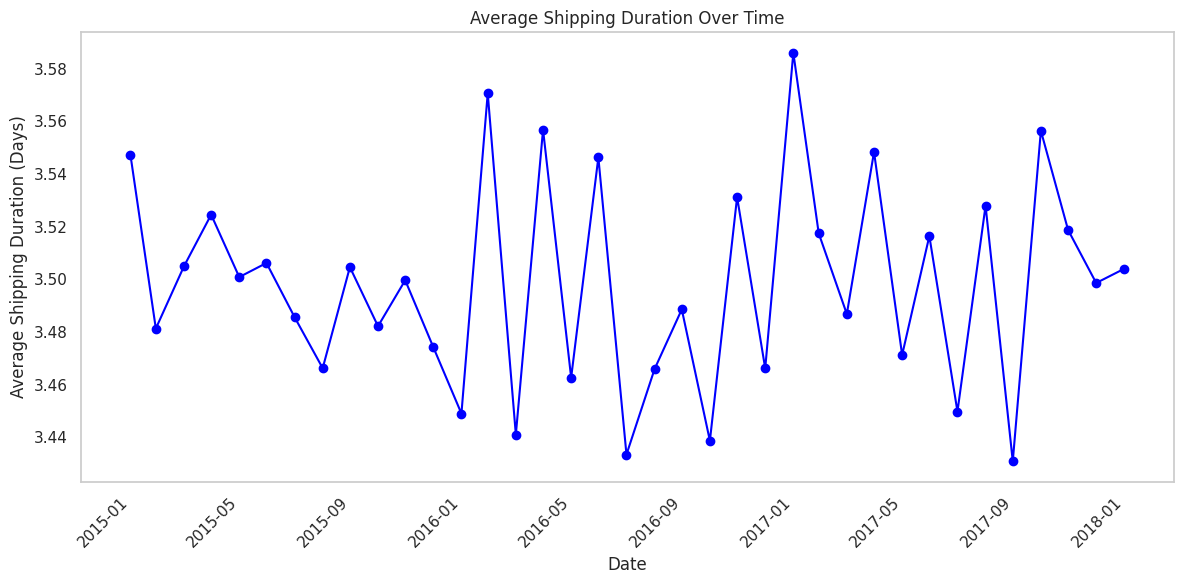

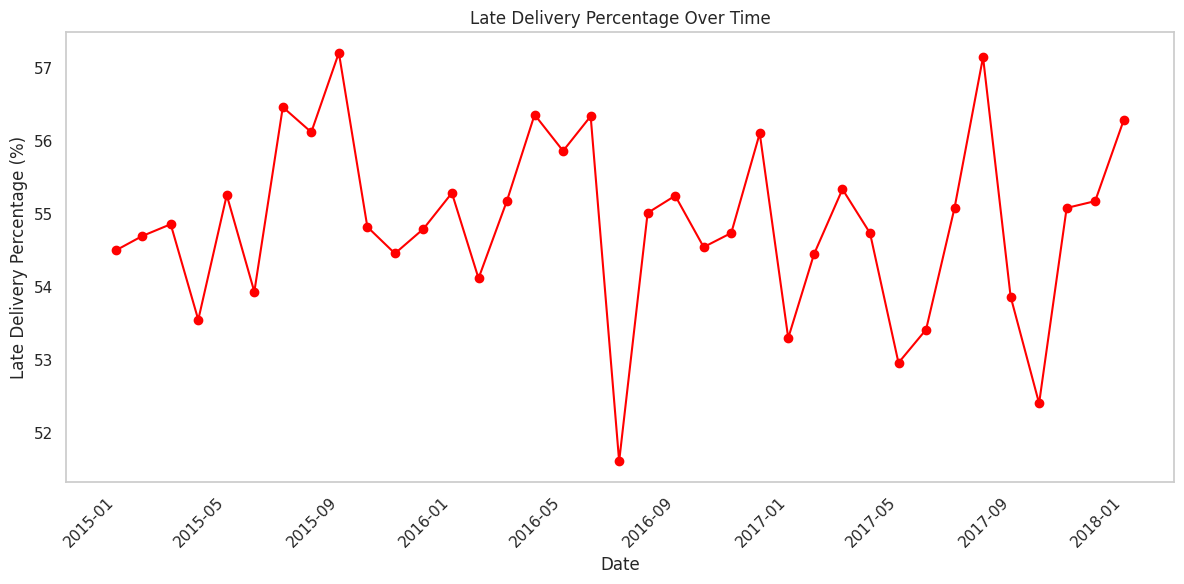

In [424]:
# Rename shipping duration
orders['Shipping Duration'] = orders['Actual days for shipping']

# Set 'Order Date' as the index
orders.set_index('Order Date', inplace=True)

# Resampling to calculate monthly average shipping duration and late delivery percentage
monthly_analysis = orders.resample('M').agg({
    'Shipping Duration': 'mean',
    'Late Delivery Risk': 'mean'  # This gives the percentage of late deliveries
}).rename(columns={'Late Delivery Risk': 'Late Delivery Percentage'})

monthly_analysis.reset_index(inplace=True)

# Time Series Analysis for Shipping Duration
plt.figure(figsize=(12, 6))
plt.plot(monthly_analysis['Order Date'], monthly_analysis['Shipping Duration'], marker='o', color='blue')
plt.title('Average Shipping Duration Over Time')
plt.xlabel('Date')
plt.ylabel('Average Shipping Duration (Days)')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

# Time Series Analysis for Late Delivery Percentage
plt.figure(figsize=(12, 6))
plt.plot(monthly_analysis['Order Date'], monthly_analysis['Late Delivery Percentage'] * 100, marker='o', color='red')
plt.title('Late Delivery Percentage Over Time')
plt.xlabel('Date')
plt.ylabel('Late Delivery Percentage (%)')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

# Insights Time Series Analysis:
# 1) Shipping Duration
#    - The average number of days for shipping appears to be relatively stable over months, ranging from 3.43 to 3.59.
# 2) Late Delivery Percentage
#    - The values over months are consistently high, indicating issues with specific suppliers or fulfillment processes.
#    - September 2015 and September 2017 are considered the 'peak' periods. The following events might have affected the supply chain:
#       - 2015 Sep: U.S. West Coast Port Strikes (Los Angeles, Long Beach, etc.) and Hurricane Joaquin.
#       - 2017 Sep: Hurricanes Harvey, Irma, and Maria at Atlantic and Labor Strikes in Spain.


     Supplier_ID  average_satisfaction  total_orders
52            53             39.872611           314
97            98             39.816273           381
107          108             39.524752           505
109          110             39.491525           295
71            72             38.962585           588
101          102             38.917749           462
72            73             38.613445           238
33            34             38.461538            13
35            36             38.026999           963
51            52             37.858770           439
108          109             37.417722           395
24            25             36.985075           335
22            23             36.754386           114
105          106             36.464844           512
13            14             36.391437           327
27            28             36.333333           150
64            65             35.673289           453
100          101             35.397260        

<ipython-input-442-6638f8f88253>:23: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




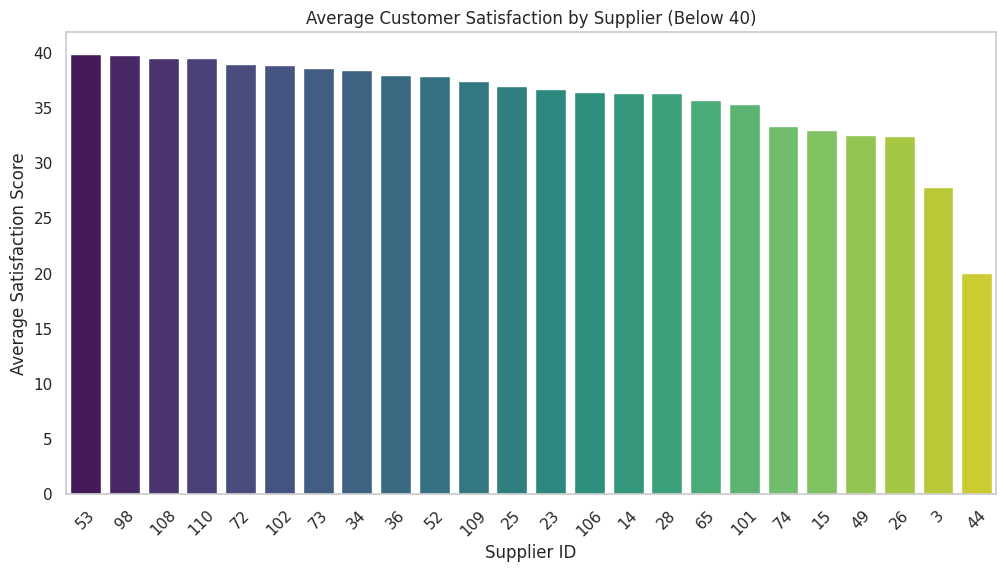


Common Suppliers in Both Lists:
[  3  14  15  23  25  26  28  34  36  44  49  52  65  73  74 101 106 109]
Percentage of common suppliers of both list in Average Customer Satisfaction by Supplier (Below 40)
75.0
Not Common Suppliers are from
['Electronics' 'Home Appliances']


In [442]:
# 3.5.5 Average Customer Satisfaction by Supplier

# Here, we assume lower late deliveries and fewer returns indicate higher satisfaction
data['Customer Satisfaction Score'] = 100 - (data['Late Delivery Risk'] * 100) - (data['Returns'] * 10)

# calculate the average customer satisfaction scores by supplier
customer_satisfaction_by_supplier = data.groupby('Supplier_ID').agg(
    average_satisfaction=('Customer Satisfaction Score', 'mean'),
    total_orders=('OrderID', 'count')
).reset_index()

# filter to only include suppliers with average satisfaction below 40
low_satisfaction_suppliers = customer_satisfaction_by_supplier[
    customer_satisfaction_by_supplier['average_satisfaction'] < 40
]

# sort the filtered DataFrame in descending order of average satisfaction
low_satisfaction_suppliers_sorted = low_satisfaction_suppliers.sort_values(by='average_satisfaction', ascending=False)
print(low_satisfaction_suppliers_sorted)

# Plot average customer satisfaction by supplier below 40 in descending order
plt.figure(figsize=(12, 6))
sns.barplot(data=low_satisfaction_suppliers_sorted, x='Supplier_ID', y='average_satisfaction', palette='viridis', order=low_satisfaction_suppliers_sorted['Supplier_ID'])
plt.title('Average Customer Satisfaction by Supplier (Below 40)')
plt.xlabel('Supplier ID')
plt.ylabel('Average Satisfaction Score')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

# Here, we will compare the lists of low_satisfaction_suppliers_sorted and underperforming_suppliers_sorted
# to see whether late delivery will lead to lesser customer satisfication

comparison = pd.merge(
    low_satisfaction_suppliers_sorted[['Supplier_ID']],
    underperforming_suppliers_sorted[['Supplier_ID']],
    on='Supplier_ID',
    how='outer',
    indicator=True
)

common_suppliers = comparison[comparison['_merge'] == 'both']
print("\nCommon Suppliers in Both Lists:")
print(common_suppliers['Supplier_ID'].unique())

# count the number of unique suppliers in low_satisfaction_suppliers_sorted
num_low_satisfaction_suppliers = low_satisfaction_suppliers_sorted['Supplier_ID'].nunique()

# count the number of unique suppliers in underperforming_suppliers_sorted
num_underperforming_suppliers = underperforming_suppliers_sorted['Supplier_ID'].nunique()

# count the number of unique common suppliers
common_suppliers = pd.merge(
    low_satisfaction_suppliers_sorted[['Supplier_ID']],
    underperforming_suppliers_sorted[['Supplier_ID']],
    on='Supplier_ID',
    how='inner'
)

num_common_suppliers = common_suppliers['Supplier_ID'].nunique()
num_low_satisfaction_suppliers, num_underperforming_suppliers, num_common_suppliers

print('Percentage of common suppliers of both list in Average Customer Satisfaction by Supplier (Below 40)')
print((num_common_suppliers/num_low_satisfaction_suppliers) * 100)

# not common suppliers
only_low_satisfaction = pd.merge(
    low_satisfaction_suppliers_sorted[['Supplier_ID']],
    data[['Supplier_ID', 'Category']],
    on='Supplier_ID',
    how='left'
).merge(
    underperforming_suppliers_sorted[['Supplier_ID']],
    on='Supplier_ID',
    how='left',
    indicator=True
).query('_merge == "left_only"').drop(columns='_merge')
unique_categories_low_satisfaction = only_low_satisfaction['Category'].unique()


print("Not Common Suppliers are from")
print(unique_categories_low_satisfaction)

# Insights Average Customer Satisfaction by Supplier:
# Ans: Based on the results, we can conclude that late delivery leads to lower customer satisfaction as they are correlated.
# The not common suppliers are also from Electronics and Home Appliances.


In [381]:
# 3.6 Model Development

# 3.6.1 Feature Selection and Train Test Data Splitting

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Selecting relevant features for prediction
features = orders[['Actual days for shipping', 'Scheduled days for shipping',
                      'Discount Percentage', 'Returns', 'Order Item Quantity',
                      'Order Region', 'Order State', 'Order City', 'Order Country']]
target = orders['Late Delivery Risk']

# Encode categorical features
label_encoders = {}
for column in ['Order Region', 'Order State', 'Order City', 'Order Country']:
    le = LabelEncoder()
    features[column] = le.fit_transform(features[column])
    label_encoders[column] = le

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)


<ipython-input-381-2c6f6649fc38>:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-381-2c6f6649fc38>:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-381-2c6f6649fc38>:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-381-

In [380]:
# 3.6.2 Random Forest Classifier (Accuracy: 98.48%)

# Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)

# Fit the model on the training data
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

accuracy, report

(0.9847531277264372,
 '              precision    recall  f1-score   support\n\n           0       0.99      0.98      0.98     53274\n           1       0.98      0.99      0.99     64783\n\n    accuracy                           0.98    118057\n   macro avg       0.99      0.98      0.98    118057\nweighted avg       0.98      0.98      0.98    118057\n')

In [382]:
# 3.6.3 Logistic Regression (Accuracy: 97.58%)

# Initialize the Logistic Regression model
logistic_model = LogisticRegression(max_iter=1000, random_state=42)

# Fit the model on the sampled training data
logistic_model.fit(X_train_sampled, y_train_sampled)

# Make predictions on the test set
y_pred_logistic = logistic_model.predict(X_test)

# Evaluate the model's performance
accuracy_logistic = accuracy_score(y_test, y_pred_logistic)
report_logistic = classification_report(y_test, y_pred_logistic)

print("Logistic Regression Accuracy:", accuracy_logistic)
print(report_logistic)


Logistic Regression Accuracy: 0.9758082959926138
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     53274
           1       0.96      1.00      0.98     64783

    accuracy                           0.98    118057
   macro avg       0.98      0.97      0.98    118057
weighted avg       0.98      0.98      0.98    118057



In [383]:
# 3.6.4 Gradient Boosting (Accuracy: 97.58%)

# Initialize the Gradient Boosting Classifier
gb_model = GradientBoostingClassifier(random_state=42)

# Fit the model on the sampled training data
gb_model.fit(X_train_sampled, y_train_sampled)

# Make predictions on the test set
y_pred_gb = gb_model.predict(X_test)

# Evaluate the model's performance
accuracy_gb = accuracy_score(y_test, y_pred_gb)
report_gb = classification_report(y_test, y_pred_gb)

print("Gradient Boosting Accuracy:", accuracy_gb)
print(report_gb)


Gradient Boosting Accuracy: 0.9758252369618066
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     53274
           1       0.96      1.00      0.98     64783

    accuracy                           0.98    118057
   macro avg       0.98      0.97      0.98    118057
weighted avg       0.98      0.98      0.98    118057



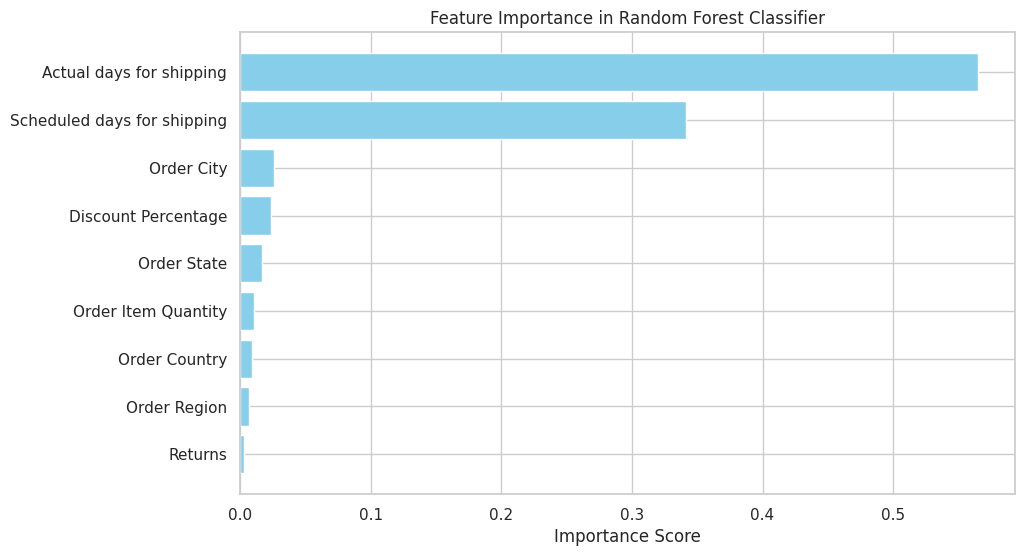

(       Actual days for shipping  Scheduled days for shipping  \
 count             324002.000000                324002.000000   
 mean                   4.085953                     2.468627   
 std                    1.710639                     1.372923   
 min                    1.000000                     0.000000   
 25%                    2.000000                     1.000000   
 50%                    5.000000                     2.000000   
 75%                    6.000000                     4.000000   
 max                    6.000000                     4.000000   
 
        Discount Percentage        Returns  Order Item Quantity  
 count        324002.000000  324002.000000        324002.000000  
 mean              0.101831       0.100379             2.164496  
 std               0.070635       0.300505             1.463108  
 min               0.000000       0.000000             1.000000  
 25%               0.040000       0.000000             1.000000  
 50%             

In [409]:
# Based on the three models tested above, Random Forest Classifier has the highest accuracy of 98.48%.

# 3.6.5 Apply Random Forest Classifier

# Get feature importances from the Random Forest model
feature_importances = rf_model_sampled.feature_importances_

# Create a DataFrame for feature importances
importance = pd.DataFrame({
    'Feature': features.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plotting the feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance['Feature'], importance['Importance'], color='skyblue')
plt.xlabel('Importance Score')
plt.title('Feature Importance in Random Forest Classifier')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()

importance

# From here, we knew that Actual Days for Shipping(0.565) and Scheduled Days for Shipping(0.341), play important role in predicting delivery outcomes.

# Filter orders with late delivery risk (Late Delivery Risk = 1)
late_deliveries = orders[orders['Late Delivery Risk'] == 1]

# Analyze the distribution of key features for late deliveries
late_delivery_summary = late_deliveries[['Actual days for shipping', 'Scheduled days for shipping',
                                          'Discount Percentage', 'Returns', 'Order Item Quantity',
                                          'Order Region', 'Order State', 'Order City', 'Order Country']]

# Summary statistics for late deliveries
late_delivery_stats = late_delivery_summary.describe()

# Count of late deliveries by Order Region
late_deliveries_by_region = late_deliveries['Order Region'].value_counts()

# Display summary statistics and the count of late deliveries by region
late_delivery_stats, late_deliveries_by_region



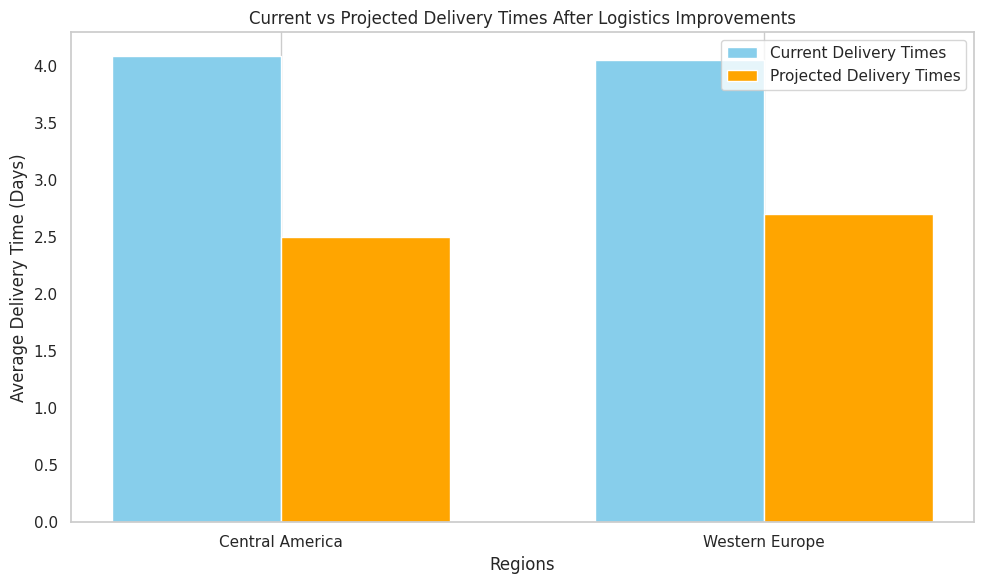

In [411]:
# Define high-risk regions
high_risk_regions = ['Central America', 'Western Europe']

# Filter the late deliveries for high-risk regions
high_risk_late_deliveries = late_deliveries[late_deliveries['Order Region'].isin(high_risk_regions)]

# Analyze key features for these high-risk regions
high_risk_summary = high_risk_late_deliveries[['Actual days for shipping', 'Scheduled days for shipping',
                                                'Discount Percentage', 'Returns', 'Order Item Quantity',
                                                'Order City', 'Order State']]

# Summary statistics for high-risk late deliveries
high_risk_stats = high_risk_summary.describe()

# Count of late deliveries by Order City within high-risk regions
late_deliveries_by_city = high_risk_late_deliveries['Order City'].value_counts()

# Display summary statistics and the count of late deliveries by city
high_risk_stats, late_deliveries_by_city.head(10)  # Show top 10 cities with late deliveries in high-risk regions

# Sample data for current and projected delivery times
regions = ['Central America', 'Western Europe']
current_delivery_times = [4.09, 4.05]  # Current average delivery times in days
projected_delivery_times = [2.5, 2.7]  # Projected average delivery times after improvements in days

# Creating the bar chart
bar_width = 0.35
x = range(len(regions))

plt.figure(figsize=(10, 6))
plt.bar(x, current_delivery_times, width=bar_width, label='Current Delivery Times', color='skyblue')
plt.bar([p + bar_width for p in x], projected_delivery_times, width=bar_width, label='Projected Delivery Times', color='orange')

# Adding labels and title
plt.xlabel('Regions')
plt.ylabel('Average Delivery Time (Days)')
plt.title('Current vs Projected Delivery Times After Logistics Improvements')
plt.xticks([p + bar_width / 2 for p in x], regions)  # Set the x-tick labels
plt.legend()
plt.grid(axis='y')

# Show the plot
plt.tight_layout()
plt.show()
